In [23]:
import copy
from functools import lru_cache
from pathlib import Path
from typing import Any, TypedDict

import evaluate
import numpy as np
import pandas as pd
import polars as pl
import torch
import torch.nn.functional as F
from datasets import Dataset
from loguru import logger
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GroupShuffleSplit
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TextClassificationPipeline,
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import (
    ModelOutput,  # or just use dict if not subclassing
)

import oxonfair
from oxonfair import group_metrics as gm


class FairnessMetrics(TypedDict):
    equal_opportunity: float
    min_recall: float
    accuracy: float
    precision: float
    recall: float


def calculate_metrics(
    test_groups: pl.Series, test_labels: pl.Series, predictions: list[str] | np.ndarray
) -> FairnessMetrics:
    groups = test_groups.to_numpy()
    preds0 = np.array(predictions)[groups == 0]
    preds1 = np.array(predictions)[groups == 1]
    labels0 = test_labels.to_numpy()[groups == 0]
    labels1 = test_labels.to_numpy()[groups == 1]

    recall1 = recall_score(y_true=labels1, y_pred=preds1)
    recall0 = recall_score(y_true=labels0, y_pred=preds0)

    min_recall = min(recall0, recall1)
    equal_opportunity = abs(recall1 - recall0)
    return {
        "min_recall": min_recall,
        "equal_opportunity": equal_opportunity,
        "accuracy": accuracy_score(y_true=test_labels.to_numpy(), y_pred=predictions),
        "precision": precision_score(y_true=test_labels, y_pred=predictions),
        "recall": recall_score(y_true=test_labels, y_pred=predictions),
    }


clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
CACHE_DIR = Path().cwd().parent / ".cache"
if not CACHE_DIR.exists():
    CACHE_DIR.mkdir()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = sigmoid(predictions)
    predictions = (predictions > 0.5).astype(int).reshape(-1)
    return clf_metrics.compute(
        predictions=predictions, references=labels.astype(int).reshape(-1)
    )


# 8. Configure training arguments
training_args = TrainingArguments(
    output_dir="multilabel_model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    label_names=["labels"],
)

Using the latest cached version of the module from /VData/resources/huggingface/modules/evaluate_modules/metrics/evaluate-metric--f1/34c46321f42186df33a6260966e34a368f14868d9cc2ba47d142112e2800d233 (last modified on Thu Mar 20 16:34:30 2025) since it couldn't be found locally at evaluate-metric--f1, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /VData/resources/huggingface/modules/evaluate_modules/metrics/evaluate-metric--precision/155d3220d6cd4a6553f12da68eeb3d1f97cf431206304a4bc6e2d564c29502e9 (last modified on Thu Mar 20 16:34:31 2025) since it couldn't be found locally at evaluate-metric--precision, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /VData/resources/huggingface/modules/evaluate_modules/metrics/evaluate-metric--recall/11f90e583db35601050aed380d48e83202a896976b9608432fba9244fb447f24 (last modified on Thu Mar 20 16:34:31 2025) since it couldn't be found locally at evaluate-metric--recall, o

In [2]:
# 3. Load tokenizer
model_path = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
def majority_vote(lists: list[list[bool]]) -> list[bool]:
    return [sum(sublist) > len(sublist) / 2 for sublist in lists]


def convert_score(score: float, threshold: float = 0.5) -> bool:
    return score > threshold


def aggregate_scores(scores: list[list[dict]], threshold: float = 0.5) -> list[bool]:
    num_preds = len(scores[0])
    # Convert to list[(pred0, pred0, pred0), (pred1, ...]
    final_preds = []
    for pred_index in range(num_preds):
        pred_list = []
        for score_list in scores:
            score_dict = score_list[pred_index]
            pred_list.append(convert_score(score_dict["score"], threshold=threshold))
        final_preds.append(pred_list)
    return majority_vote(final_preds)


def max_index_by_key(lst: list[dict], key: str = "score"):
    if not lst:
        return None
    return max(range(len(lst)), key=lambda i: lst[i][key])


def ensemble_predict(texts: list[str], ensemble: list[Trainer]) -> list[int]:
    device = ensemble[0].model.device  # Get device from first model
    pipes = [
        TextClassificationPipeline(
            tokenizer=tokenizer,
            model=trainer.model.to(device),
            device=device,
            truncation=True,
        )
        for trainer in ensemble
    ]
    preds = [pipe(texts) for pipe in pipes]
    return aggregate_scores(preds)


def get_full_data():
    english_hatespeech = Path().cwd().parent / "hatespeech-data" / "split" / "English"
    all_data = list(english_hatespeech.glob("*.tsv"))
    return (
        pl.DataFrame(
            pd.concat([pd.read_csv(f, sep="\t") for f in all_data]).drop(
                columns=["city", "state", "country", "date"]
            )
        )
        .with_columns(
            pl.col("gender").replace("x", None).cast(pl.Int8),
            pl.col("age").replace("x", None).cast(pl.Int8),
            pl.col("ethnicity").replace("x", None).cast(pl.Int8),
        )
        .drop_nulls()
        .rename({"label": "target"})
    )


def create_dataset(
    features: pl.DataFrame, labels: pl.Series, feature_names: list[str] | None = None
) -> Dataset:
    if feature_names is None:
        feature_names = features.columns
    feature_dict = {feature: features[feature].to_list() for feature in feature_names}
    return Dataset.from_dict(
        {
            **feature_dict,
            "target": labels.to_list(),
        }
    )


@lru_cache
def tokenize(text: str) -> dict[str, Any]:
    return tokenizer(text, truncation=True)


def preprocess_simple(example: dict[str, Any]) -> dict[str, Any]:
    tokenized = tokenize(example["text"])
    labels = [float(example[key]) for key in ["target", "gender"]]
    tokenized["labels"] = labels
    return tokenized


def compute_loss_func(
    outputs: ModelOutput | dict,
    labels: torch.Tensor,
    num_items_in_batch: int,  # noqa: ARG001
) -> torch.Tensor:
    """
    Custom loss function for HuggingFace Trainer:
    - Binary log loss for the first element
    - Squared loss (MSE) for the remaining elements

    Args:
        outputs: ModelOutput or dict containing 'logits' of shape (batch_size, num_outputs)
        labels: Tensor of shape (batch_size, num_outputs), ground-truth labels
        num_items_in_batch: Total number of items in the accumulated batch (unused here)
        num_classification_labels: Number of non-group based classification labels (default: 2)

    Returns:
        Scalar tensor representing the combined loss
    """
    logits = outputs.logits if hasattr(outputs, "logits") else outputs["logits"]

    log_loss = F.binary_cross_entropy_with_logits(logits[:, :1], labels[:, :1])

    # Regression loss (MSE) for remaining outputs
    if logits.shape[1] > 1:
        mse_loss = F.mse_loss(logits[:, 1:], labels[:, 1:])
        loss = log_loss + mse_loss
    else:
        loss = log_loss

    return loss


combined = get_full_data().sample(fraction=0.2)

# 5. Prepare data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# 6. Metrics function
# 7. Initialize model


K = 10
gss = GroupShuffleSplit(n_splits=K, train_size=0.8, random_state=110)
all_features = combined.drop("target", "tid", "uid", "age", "ethnicity")
all_labels = combined["target"]
all_users = combined["uid"]

test_metrics = []
all_metrics: list[pd.DataFrame] = []
for iteration, (train_index, test_index) in enumerate(
    gss.split(all_features, all_labels, groups=all_users)
):
    train_features = all_features[train_index]
    train_labels = all_labels[train_index]
    train_groups = all_users[train_index]
    test_features = all_features[test_index]
    test_labels = all_labels[test_index]

    inner_gss = GroupShuffleSplit(n_splits=2, train_size=0.8, random_state=110)
    # nested cross-validation
    # Run oxonfair on an outer
    # Min recall as a key metric for each test partition
    # Key question: how big do we need to make the delta min recall to matter on the text
    fair_ensemble = []
    metrics = []
    inner_gss = GroupShuffleSplit(n_splits=3, train_size=0.8, random_state=110)
    for i, (inner_train_index, validation_index) in enumerate(
        inner_gss.split(train_features, train_labels, groups=train_groups)
    ):
        inner_train_features = train_features[inner_train_index]
        inner_train_labels = train_labels[inner_train_index]
        inner_train_groups = train_groups[inner_train_index]
        inner_validation_features = train_features[validation_index]
        inner_validation_labels = train_labels[validation_index]
        inner_validation_groups = train_groups[validation_index]
        assert inner_validation_groups.shape[0] == validation_index.shape[0]
        model = AutoModelForSequenceClassification.from_pretrained(
            model_path,
            num_labels=2,
            problem_type="multi_label_classification",
        )

        train_dataset = create_dataset(
            inner_train_features,
            inner_train_labels,
        ).map(preprocess_simple)

        validation_dataset = create_dataset(
            inner_validation_features,
            inner_validation_labels,
        ).map(preprocess_simple)
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=validation_dataset,
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_loss_func=compute_loss_func,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        # Run oxonfair here? to merge heads etc.
        val_output = trainer.predict(validation_dataset)
        fpred = oxonfair.DeepFairPredictor(
            inner_validation_labels.to_numpy(),
            val_output.predictions,
            groups=np.array(validation_dataset["gender"]),
        )
        fpred.fit(gm.accuracy, gm.equal_opportunity, 0.02, grid_width=75)
        fair_network = copy.deepcopy(trainer)
        fair_network.model.classifier = fpred.merge_heads_pytorch(
            fair_network.model.classifier
        )
        performance = fpred.evaluate().assign(classifier=i, metric_type="performance")
        fairness = fpred.evaluate_fairness(
            metrics=gm.default_fairness_measures | {"min_recall": gm.recall.min}
        ).assign(classifier=i, metric_type="fairness")
        metrics.append(pd.concat([performance, fairness]))
        fair_ensemble.append(fair_network)
    all_metrics.append(pd.concat(metrics).assign(iteration=iteration))
    logger.info("Done training ensemble! Evaluating on test set")
    test_dataset = create_dataset(
        test_features,
        test_labels,
    ).map(preprocess_simple)
    logger.debug("Evaluating ensemble...")
    ensemble_preds = ensemble_predict(
        texts=test_dataset["text"], ensemble=fair_ensemble
    )
    ensemble_metrics = calculate_metrics(
        test_groups=test_features["gender"],
        test_labels=test_labels,
        predictions=ensemble_preds,
    )
    logger.debug("Evaluating first member...")
    single_preds = ensemble_predict(
        texts=test_dataset["text"], ensemble=fair_ensemble[:1]
    )
    single_metrics = calculate_metrics(
        test_groups=test_features["gender"],
        test_labels=test_labels,
        predictions=single_preds,
    )
    single_df = pd.DataFrame([single_metrics]).assign(model_type="single")
    test_metric_df = pd.concat(
        [single_df, pd.DataFrame([ensemble_metrics]).assign(model_type="ensemble")]
    ).assign(iteration=iteration)
    test_metrics.append(test_metric_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1223/1223 [00:00<00:00, 8574.93 examples/s]
/tmp/ipykernel_3439903/3999273676.py:176: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.648025,0.679068,0.715889,0.614667,0.857019
2,No log,0.600651,0.690515,0.732603,0.618366,0.898614
3,0.601400,0.616856,0.686018,0.730526,0.613797,0.902080


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1236/1236 [00:00<00:00, 8185.04 examples/s]
/tmp/ipykernel_3439903/3999273676.py:176: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.653099,0.673544,0.702324,0.596118,0.854578
2,No log,0.644704,0.678398,0.711852,0.596960,0.881508
3,0.613700,0.659259,0.677994,0.712635,0.596014,0.885996


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 2249/2249 [00:00<00:00, 9204.08 examples/s]
/tmp/ipykernel_3439903/3999273676.py:176: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.650176,0.778791,0.801516,0.706399,0.926233
2,No log,0.739308,0.740774,0.779417,0.660892,0.949746
3,No log,0.721889,0.753001,0.786387,0.674472,0.942831


2025-04-09 10:23:34.451 | INFO     | __main__:<module>:204 - Done training ensemble! Evaluating on test set
Map: 100%|██████████| 1526/1526 [00:00<00:00, 7972.77 examples/s]
2025-04-09 10:23:34.653 | DEBUG    | __main__:<module>:209 - Evaluating ensemble...
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
2025-04-09 10:24:38.350 | DEBUG    | __main__:<module>:216 - Evaluating first member...
Device set to use cuda:0
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 2233/2233 [00:00<00:00, 9010.47 examples/s]
/tmp/ipykernel_3439903/3999273676.py:176: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  train

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.597568,0.794223,0.810242,0.724252,0.919400
2,No log,0.601262,0.796014,0.812513,0.724404,0.925023
3,No log,0.651590,0.782579,0.804824,0.704681,0.938144


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1227/1227 [00:00<00:00, 8829.08 examples/s]
/tmp/ipykernel_3439903/3999273676.py:176: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.624148,0.681337,0.708644,0.600379,0.864545
2,No log,0.602093,0.686634,0.717175,0.602224,0.886364
3,0.584000,0.615747,0.685819,0.718099,0.600612,0.892727


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 2235/2235 [00:00<00:00, 8478.61 examples/s]
/tmp/ipykernel_3439903/3999273676.py:176: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.667243,0.786353,0.807498,0.721022,0.917545
2,No log,0.635986,0.787919,0.811531,0.716895,0.934952
3,No log,0.640874,0.785906,0.810081,0.714636,0.934952


2025-04-09 10:29:14.679 | INFO     | __main__:<module>:204 - Done training ensemble! Evaluating on test set
Map: 100%|██████████| 1753/1753 [00:00<00:00, 8946.17 examples/s]
2025-04-09 10:29:14.883 | DEBUG    | __main__:<module>:209 - Evaluating ensemble...
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
2025-04-09 10:30:28.155 | DEBUG    | __main__:<module>:216 - Evaluating first member...
Device set to use cuda:0
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 2243/2243 [00:00<00:00, 9164.08 examples/s]
/tmp/ipykernel_3439903/3999273676.py:176: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  train

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.646348,0.792911,0.817090,0.719736,0.944900
2,No log,0.591810,0.812082,0.828763,0.748075,0.928962
3,No log,0.620523,0.799376,0.822974,0.724377,0.952641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1219/1219 [00:00<00:00, 8640.17 examples/s]
/tmp/ipykernel_3439903/3999273676.py:176: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.635686,0.680476,0.711588,0.604783,0.864209
2,No log,0.601604,0.681296,0.714443,0.604102,0.874101
3,0.585000,0.618900,0.682937,0.719011,0.603417,0.889388


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 2248/2248 [00:00<00:00, 9276.36 examples/s]
/tmp/ipykernel_3439903/3999273676.py:176: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.659510,0.803603,0.821219,0.737455,0.926450
2,No log,0.607633,0.810943,0.827726,0.743898,0.932846
3,No log,0.663349,0.799155,0.820655,0.725931,0.943810


2025-04-09 10:35:08.564 | INFO     | __main__:<module>:204 - Done training ensemble! Evaluating on test set
Map: 100%|██████████| 1753/1753 [00:00<00:00, 6204.30 examples/s]
2025-04-09 10:35:08.856 | DEBUG    | __main__:<module>:209 - Evaluating ensemble...
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
2025-04-09 10:36:23.607 | DEBUG    | __main__:<module>:216 - Evaluating first member...
Device set to use cuda:0


In [32]:
pd.concat(test_metrics).to_csv("../hatespeech-data/test_metrics.csv", index=False)
pd.concat(all_metrics).to_csv("../hatespeech-data/validation_metrics.csv", index=False)

In [41]:
all_test_metrics = pd.concat(test_metrics)
all_test_metrics


fpred.fit(gm.accuracy, gm.recall.min, 0.75, grid_width=75)

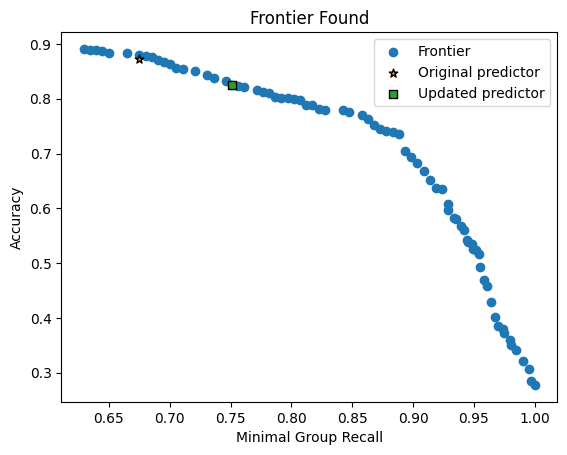

In [42]:
fpred.plot_frontier()

In [9]:
import os
from pathlib import Path

import polars as pl

DATA_DIR = Path("../hatespeech-data")
latest_test_metrics_path = list(DATA_DIR.glob("test_metrics*.csv"))
latest_test_metrics_path.sort(key=os.path.getctime)

test_metrics_latest = pl.read_csv(latest_test_metrics_path[1])

In [10]:
test_metrics_latest

min_recall,equal_opportunity,accuracy,precision,recall,model_type,iteration
f64,f64,f64,f64,f64,str,i64
0.446043,0.072164,0.720077,0.739234,0.486614,"""single""",0
0.535971,0.057866,0.768983,0.809417,0.568504,"""ensemble""",0
0.72619,0.028411,0.819843,0.771583,0.742215,"""single""",1
0.611111,0.029993,0.81201,0.832569,0.628028,"""ensemble""",1
0.313576,0.181305,0.675676,0.844262,0.378676,"""single""",2
…,…,…,…,…,…,…
0.580153,0.072844,0.821128,0.86506,0.620035,"""ensemble""",17
0.592593,0.01834,0.733032,0.657895,0.60241,"""single""",18
0.503704,0.065428,0.811248,0.928783,0.538726,"""ensemble""",18


In [19]:
pivoted_metrics = test_metrics_latest.select(
    "iteration", "model_type", "min_recall"
).pivot(on="model_type", index="iteration")
pivoted_metrics.with_columns(
    (pl.col("single") < pl.col("ensemble")).alias("hypothesis_true")
)["hypothesis_true"].mean()

0.45

In [20]:
test_metrics_latest.columns

['min_recall',
 'equal_opportunity',
 'accuracy',
 'precision',
 'recall',
 'model_type',
 'iteration']

In [23]:
test_metrics_latest

min_recall,equal_opportunity,accuracy,precision,recall,model_type,iteration
f64,f64,f64,f64,f64,str,i64
0.446043,0.072164,0.720077,0.739234,0.486614,"""single""",0
0.535971,0.057866,0.768983,0.809417,0.568504,"""ensemble""",0
0.72619,0.028411,0.819843,0.771583,0.742215,"""single""",1
0.611111,0.029993,0.81201,0.832569,0.628028,"""ensemble""",1
0.313576,0.181305,0.675676,0.844262,0.378676,"""single""",2
…,…,…,…,…,…,…
0.580153,0.072844,0.821128,0.86506,0.620035,"""ensemble""",17
0.592593,0.01834,0.733032,0.657895,0.60241,"""single""",18
0.503704,0.065428,0.811248,0.928783,0.538726,"""ensemble""",18


<Axes: xlabel='metric', ylabel='value'>

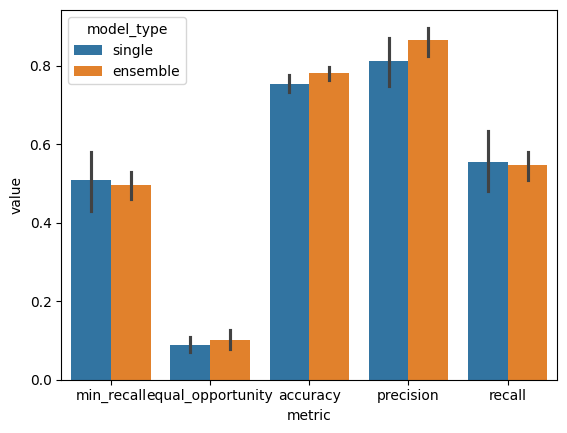

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

test_metrics_latest_long = test_metrics_latest.unpivot(
    index=["model_type", "iteration"], variable_name="metric"
)
sns.barplot(test_metrics_latest_long, x="metric", y="value", hue="model_type")

plt.xticks()

In [19]:
ensemble_preds = ensemble_predict(texts=test_dataset["text"], ensemble=fair_ensemble)

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [61]:
single_preds = ensemble_predict(texts=test_dataset["text"], ensemble=fair_ensemble[:1])

Device set to use cuda:0


min_recall=np.float64(0.6547945205479452)
equal_opportunity=np.float64(0.027376022087713725)


In [38]:
type(test_features)

polars.dataframe.frame.DataFrame

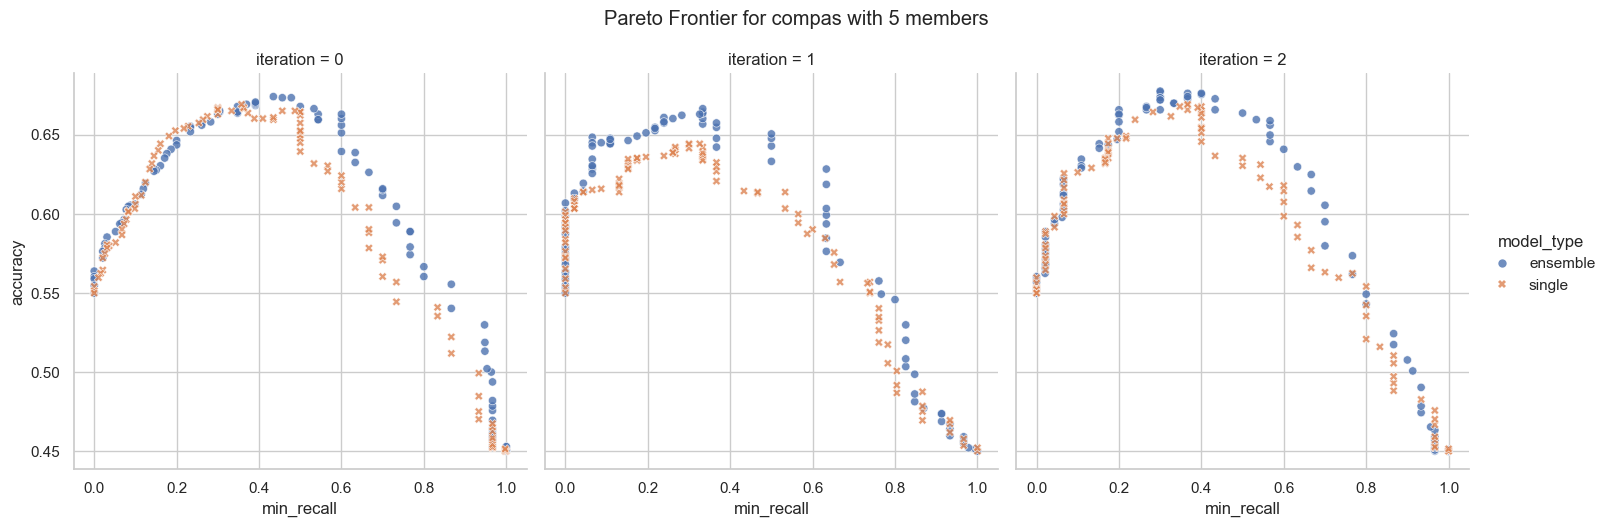

In [164]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

DATASET = "compas"
ITERATIONS = 3
MEMBERS = 5
METRIC = "min_recall"
threshold_metrics = pl.read_csv(
    f"../ensemble_results/threshold_metrics_{DATASET}-n{MEMBERS}-i{ITERATIONS}-metric_{METRIC}.csv"
).with_columns(pl.lit("ensemble").alias("model_type"))
threshold_metrics_single = pl.read_csv(
    f"../ensemble_results/single_threshold_metrics_{DATASET}-n{MEMBERS}-i{ITERATIONS}-metric_{METRIC}.csv"
).with_columns(pl.lit("single").alias("model_type"))


all_metrics = pl.concat([threshold_metrics, threshold_metrics_single])

sns.relplot(
    all_metrics,
    x=METRIC,
    y="accuracy",
    col="iteration",
    hue="model_type",
    alpha=0.8,
    style="model_type",
)
plt.suptitle(f"Pareto Frontier for {DATASET} with {MEMBERS} members", y=1.05)
plt.savefig(
    f"../plots/{DATASET}-n{MEMBERS}-i{ITERATIONS}-{METRIC}-threshold_metrics.png"
)

In [126]:
all_metrics.filter((pl.col("min_recall") < 0.9) & (pl.col("min_recall") > 0.8))

min_recall,equal_opportunity,accuracy,precision,recall,demographic_parity,recall_group_ Amer-Indian-Eskimo,recall_group_ Asian-Pac-Islander,recall_group_ Black,recall_group_ Other,recall_group_ White,threshold,iteration,model_type
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
0.818182,0.181818,0.683968,0.429219,0.973042,0.280121,0.818182,0.95122,0.938053,1.0,0.976426,0.828283,0,"""ensemble"""
0.818182,0.181818,0.683968,0.429192,0.972614,0.280121,0.818182,0.95122,0.938053,1.0,0.975955,0.828283,0,"""single"""


In [111]:
all_metrics.select("min_recall", "model_type", "threshold")

min_recall,model_type,threshold
f64,str,f64
1.0,"""ensemble""",0.0
1.0,"""ensemble""",0.010101
1.0,"""ensemble""",0.020202
1.0,"""ensemble""",0.030303
1.0,"""ensemble""",0.040404
…,…,…
0.545455,"""single""",0.959596
0.545455,"""single""",0.969697
0.545455,"""single""",0.979798


In [82]:
metrics = pl.read_csv("../ensemble_results/ensemble_results-n3-i3.csv")
ensemble_recall = metrics.unpivot(
    on=pl.selectors.starts_with("recall_group_"),
    index=["iteration"],
    value_name="ensemble_recall",
    variable_name="group",
).with_columns(pl.col("group").str.strip_prefix("recall_group_"))

ensemble_der = metrics.unpivot(
    on=pl.selectors.starts_with("der_group_"),
    index=["iteration"],
    value_name="der",
    variable_name="group",
).with_columns(
    pl.col("group").str.strip_prefix("der_group_"),
)
ensemble_recall

iteration,group,ensemble_recall
i64,str,f64
0,""" Amer-Indian-Eskimo""",0.636364
1,""" Amer-Indian-Eskimo""",0.636364
2,""" Amer-Indian-Eskimo""",0.727273
0,""" Asian-Pac-Islander""",0.914634
1,""" Asian-Pac-Islander""",0.963415
…,…,…
1,""" Other""",0.9
2,""" Other""",0.9
0,""" White""",0.939651


In [83]:
from pathlib import Path

individual_metrics = pl.concat(
    [
        pl.read_csv(f)
        for f in Path("../ensemble_results").glob("individual_metrics_original-i*.csv")
    ]
)
individual_recall = (
    individual_metrics.filter(pl.col("dataset") == "test")
    .unpivot(
        index=["member", "iteration"],
        on=pl.selectors.starts_with("recall_group_"),
        value_name="recall",
        variable_name="group",
    )
    .with_columns(
        pl.col("group").str.strip_prefix("recall_group_"),
    )
)
individual_recall

member,iteration,group,recall
i64,i64,str,f64
0,2,""" Amer-Indian-Eskimo""",0.818182
1,2,""" Amer-Indian-Eskimo""",0.727273
2,2,""" Amer-Indian-Eskimo""",0.727273
0,0,""" Amer-Indian-Eskimo""",0.636364
1,0,""" Amer-Indian-Eskimo""",0.454545
…,…,…,…
1,0,""" White""",0.806223
2,0,""" White""",0.991985
0,1,""" White""",0.937765


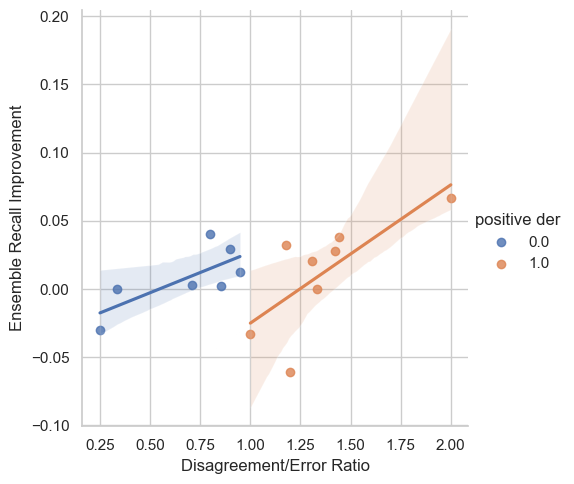

In [ ]:
sns.set_theme(style="whitegrid")
joined_recall_der = (
    individual_recall.join(ensemble_recall, on=["group", "iteration"])
    .join(ensemble_der, on=["group", "iteration"])
    .with_columns(
        (pl.col("ensemble_recall") - pl.col("recall")).alias(
            "ensemble recall improvement"
        )
    )
    .cast({"member": pl.String})
    .with_columns((pl.col("der") > 1).alias("positive der"))
    .group_by("iteration", "group")
    .mean()
)

sns.lmplot(
    joined_recall_der,
    x="der",
    y="ensemble recall improvement",
    hue="positive der",
)
plt.xlabel("Disagreement/Error Ratio")
plt.ylabel("Ensemble Recall Improvement")
plt.savefig("../plots/ensemble_recall_improvement.png")

In [89]:
joined_recall_der.group_by("group", "iteration").agg(
    pl.col("ensemble recall improvement").mean(),
    pl.col("der").mean(),
)

group,iteration,ensemble recall improvement,der
str,i64,f64,f64
""" Other""",1,0.0,1.333333
""" Amer-Indian-Eskimo""",1,0.0,0.333333
""" White""",2,0.012101,0.948339
""" Asian-Pac-Islander""",1,0.03252,1.176471
""" Black""",0,0.038348,1.44186
…,…,…,…
""" Black""",2,0.029499,0.9
""" Other""",0,0.066667,2.0
""" Asian-Pac-Islander""",0,0.020325,1.307692


In [55]:
joined_recall_der

member,group,recall,ensemble_recall,der,ensemble recall improvement
i64,str,f64,f64,f64,f64
0,""" Amer-Indian-Eskimo""",0.454545,0.727273,1.125,0.272727
1,""" Amer-Indian-Eskimo""",0.909091,0.727273,1.125,-0.181818
2,""" Amer-Indian-Eskimo""",0.454545,0.727273,1.125,0.272727
3,""" Amer-Indian-Eskimo""",1.0,0.727273,1.125,-0.272727
4,""" Amer-Indian-Eskimo""",0.727273,0.727273,1.125,0.0
…,…,…,…,…,…
0,""" White""",0.865629,0.961339,1.48623,0.09571
1,""" White""",0.988685,0.961339,1.48623,-0.027346
2,""" White""",0.690712,0.961339,1.48623,0.270627
